In [1]:
library(rlang)
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)
library("dplyr")
library(RCTdesign)
library(ggplot2)

Warning message:
“package ‘rlang’ was built under R version 3.4.4”Warning message:
“package ‘repr’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.2.5     
✔ tibble  2.0.1          ✔ dplyr   0.7.8     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.1.1          ✔ forcats 0.3.0     
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.4”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::as_function() masks rlang::a

In [2]:
# devtools::install_github("tidyverse/ggplot2")

In [14]:
# Data operations
group_data <- function(df, grouping_feature, group_size=25, testset=NULL) {
    # Takes Sherpa dataframe and returns dataframe with 
    # Lambda (i.e. group), Group mean and Psi
    #
    # Args:
    #     df: Sherpa output dataframe.
    #     grouping_feature: feature to group by.
    #
    # Returns:
    #     tbl: Lambda (i.e. group), Group mean and Psi
    names(df)[names(df) == grouping_feature] <- 'grouping_feature'
    if (!is.null(testset)) {
        names(df)[names(df) == testset] <- 'PsiTest'
    }
    df <- as_tibble(df)
    grpdf <- df %>% group_by_at('grouping_feature') %>%
            summarise(mean=mean(Objective), count=n()) %>%
            filter(count==group_size) %>%
            arrange(mean) %>%
            mutate(Lambda = 1:n()) %>%
            inner_join(df, by='grouping_feature') %>%
            rename(Psi=Objective, Mean=mean)
    grpdf <- grpdf %>% select(Lambda, starts_with("Psi"))
    
    return(grpdf)
}

subsample_groups <- function(tbl, num_groups) {
    # Helper to subsample by hyperparameter setting (Lambda).
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_groups: the number to subsample i.e. K
    #
    # Returns:
    #     The subsampled tibble.
    return(filter(tbl, Lambda %in% sample(unique(tbl$Lambda), num_groups, replace=F)))
}

subsample_trials <- function(tbl, num_trials, replace=F) {
    # Helper to subsample trials for the existing groups.
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_trials: the number to subsample i.e. n_lambda
    #
    # Returns:
    #     The subsampled tibble.
    return(tbl %>% group_by(Lambda) %>% sample_n(num_trials, replace=replace))
}

add_trials <- function(tbl, newtbl) {
    # Helper to combine new trials with previous.
    #
    # Args:
    #     tbl: the dataframe/tibble with the previous trials.
    #     newtbl: the dataframe with the new trials.
    #
    # Returns:
    #     The joined tibble.
    return(full_join(tbl, newtbl, by=c("Lambda", "Psi")) %>%
           arrange(Lambda))
}

select_lambda_star <- function(tbl) {
    # Return the trials that have minimum observed mean.
    #
    # Args:
    #     tbl: the available trials.
    #
    # Returns:
    #     tibble that contains only trials from lambda star.
    return(tbl  %>% 
                group_by(Lambda) %>% 
                summarise(ObservedMean=mean(Psi)) %>% 
                arrange(ObservedMean) %>% 
                mutate(Rank=1:n()) %>% 
                inner_join(tbl, 'Lambda') %>% filter(Rank==1))
}

In [15]:
# CalcPocockErrorAndSampleSize <- function (n, alpha){
#     # Calculate the alpha dash values and sample size for interim analyses
#     #
#     # Args:
#     #   n: vector of sample size at each analysis.
#     #   alpha: overall type 1 error.
#     #
#     # Returns:
#     #   A list containing alpha dash and the sample size at each analysis.
#     if (length(n) > 1){
#         if (length(n) == 3) {
#             alpha.dash <- rep(0.02317456, 3)
#         } else if (length(n) == 5) {
#             alpha.dash <- rep(0.01693147, 5)
#         } else {
#             information.fraction <- n/max(n)
#             spent.error <- alpha * log(1+(exp(1)-1)*information.fraction)
#             alpha.dash <- c(spent.error[1], diff(spent.error))
#         }
#         n.delta <- c(n[1], diff(n))
#     } else {
#         alpha.dash <- alpha
#         n.delta <- n
#     }
#     return(list(alpha.dash=alpha.dash, n.delta=n.delta))
# }

CalcPocockErrorAndSampleSize <- function (n, alpha, P=0.5){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        n.delta <- c(n[1], diff(n))
        d <- seqDesign( prob.model="normal",
                       arms=1,
                       alpha=alpha,
                       sample.size=n,
                       P=P,
                       design.scale="E",
                       early.stopping="alternative")
        z.dash <- as.numeric(seqBoundary(d,scale="Z")[,4])
        alpha.dash <- 1.-pnorm(z.dash)
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}


filter_by_anova <- function(df, alpha=0.05, verbose=T) {
    # Binary Search ANOVA
    #
    # Args:
    #     df: available trials with grouping variable Lambda
    #     alpha: type I error level
    #     verbose: option for turn output on/off
    #
    # Returns:
    #     Tibble of found nullset.
    df <- df  %>% 
        group_by(Lambda) %>% 
        summarise(ObservedMean=mean(Psi)) %>% 
        arrange(ObservedMean) %>% 
        mutate(Rank=1:n()) %>% 
        inner_join(df, 'Lambda')
    K <- max(df$Rank)
    l <- 1
    h <- K
    p <- h
    count <- 1
    while(l != h){

        pval <- anova(lm(Psi ~ factor(Lambda), df, subset=Rank<=p))$'Pr(>F)'[1]
#         reject <- pval < alpha/ceiling(log2(K)+1)
        reject <- pval < alpha
        if (verbose) {
            cat(paste("Test ", count, "/", ceiling(log2(K)+1), "\n",
                      "l=",l," h=",h," p=",p,"\n",
                      ifelse(reject,"Reject", "Accept"), " (p-val=", pval, ")", "\n\n"
                      , sep=""))
        }
        if(reject){
            h <- p - 1
        } else {
            l <- p
        }
        p <- ceiling((l+h)/2)
        count <- count + 1
    }
    if (verbose) {cat(paste("l=",l," h=",h,"\n", sep=""))}
    return(filter(df, Rank<=l) %>% select(Lambda, Psi))
}


FilterTrials <- function(tbl, alpha.dash, n.lambda.delta) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   tbl: data frame containing all available trials
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   Tibble containing trials in H0.
    num.trials <- 0
    
    # H and H0 denote indices with respect to psi
    for (i in 1:length(n.lambda.delta)){
        new.trials <- subsample_trials(tbl, n.lambda.delta[i], replace=F)
        
        tbl <- anti_join(tbl, new.trials, by = c("Lambda", "Psi"))
        if (i > 1) {
            new.trials <- filter(new.trials, Lambda %in% unique(trials$Lambda))
            trials <- add_trials(trials, new.trials)
        } else {
            trials <- new.trials
        }
        num.trials <- num.trials + nrow(new.trials)
        
        if (n.lambda.delta[i]==1 && length(n.lambda.delta)==1) {
            trials <- filter(trials, Psi==min(trials$Psi))
        } else {
            trials <- filter_by_anova(trials, alpha=alpha.dash[i], verbose=F)
        }
    }
    return(list(H0=trials, num.trials=num.trials))
}

GetLambdaStarPopulation <- function(tbl, H0, sample=F) {
    if (length(unique(H0$Lambda)) > 1) {
        if (sample) {
                lambda.star.sample <- filter(tbl, Lambda==sample(unique(H0$Lambda), 1))
        } else {
            lambda.star.sample <- select_lambda_star(H0)
        }
    } else {
        lambda.star.sample <- H0
    }
    lambda.star.population <- filter(tbl, Lambda %in% unique(lambda.star.sample$Lambda))
    return(lambda.star.population)
}
TestGetLambdaStarPopulation <- function() {
    H0 <- FilterTrials(subsample_groups(mnist, 50), c(5), alpha=0.05)$H0
    print(unique(H0$Lambda)[1] == GetLambdaStarPopulation(mnist,H0,sample=F)$Lambda[1])
    print(GetLambdaStarPopulation(mnist,H0,sample=T)$Lambda[1] %in% unique(H0$Lambda))
}
TestGetLambdaStarPopulation()

plot_groups <- function(df, xlab="Loss") {
    # Helper to make quick plots of the groups.

    # Args:
    #     df: dataframe/tibble containing groups
    #         with at least a Lambda and Psi column.

    # Returns:
    #     Plot.
    p <- ggplot(df, aes(x=Psi, fill=factor(Lambda)))
    p <- p + geom_density(alpha=0.4)
    p <- p + labs(fill = "HP Setting", x=xlab, y="Density")
    return(p)
}

EvalMetrics <- function(tbl, n.lambda, alpha, num.runs, K, testset=F, P=0.5) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    epe.sampled <- rep(NA, num.runs)
    epe.best <- rep(NA, num.runs)
    epe.sampled.test <- rep(NA, num.runs)
    epe.best.test <- rep(NA, num.runs)
    
    boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=P)
    alpha.dash <- boundary$alpha.dash
    n.lambda.delta <- boundary$n.delta
    
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)
        filteredTbl <- rval$H0
        
        num.trials[i] <- rval$num.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
        
        sampled.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=T)
        epe.sampled[i] <- mean(sampled.lambda.star.population$Psi)
        
        
        best.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=F)
        epe.best[i] <- mean(best.lambda.star.population$Psi)
        
        if (testset) {
            epe.sampled.test[i] <- mean(sampled.lambda.star.population$PsiTest)
            epe.best.test[i] <- mean(best.lambda.star.population$PsiTest)
        }

    }
    
    return(list('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$'=mean(lambda.star.in.H0),
                '$\\bar{|\\mathcal{H}_0|}$'=mean(H0.size),
                '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$'=mean(rejection.power),
                'Avg Evaluations'=mean(num.trials),
                '$Mean[E(\\Psi(\\lambda^*))]$'=mean(epe.best),
                '$Var[E(\\Psi(\\lambda^*))]$'=var(epe.best),
                '$Mean[E(\\Psi(\\lambda^s))]$'=mean(epe.sampled),
                '$Var[E(\\Psi(\\lambda^s))]$'=var(epe.sampled),
                '$Mean[E(\\Psi^T(\\lambda^*))]$'=mean(epe.best.test),
                '$Var[E(\\Psi^T(\\lambda^*))]$'=var(epe.best.test),
                '$Mean[E(\\Psi^T(\\lambda^s))]$'=mean(epe.sampled.test),
                '$Var[E(\\Psi^T(\\lambda^s))]$'=var(epe.sampled.test)
    ))
}

[1] TRUE
[1] TRUE


In [16]:
TableCreator <- function(results=NULL, caption="", label="") {
    cat(paste("\\begin{table}\n",
              "\\caption{", caption, "\\label{tab:", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{l", paste(rep("c", 5), sep="", collapse=""),"}\n",
              "\\toprule\n", sep=""))
    
    cat(paste(paste(c("$n_\\lambda$", names(results[[1]])), collapse=" & "), "\\\\\n"))
    
    for(K in names(results)){
        cat("\n\\midrule\n")
        cat(paste("$K=", K, "$", paste(rep("&", 5), sep="", collapse=""), "\\\\\n"))
        for(m in c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                '$\\bar{|\\mathcal{H}_0|}$',
                '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                'Avg Evaluations')){
            row <- NULL
            for(n in names(results[[K]])) {
                row <- c(row, as.character(round(results[[K]][[n]][[m]], 3)))
            }
            cat(paste(paste(c(m, row), collapse=" & "),"\\\\", "\n"))
        }   
    }
    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
    
}

In [25]:
TableMeanVar <- function(results=NULL, adj.k) {
    caption <- ""
    label <- "tab:meanvar-results"
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{lccc}\n",
              "\\toprule\n",
              "\\multicolumn{1}{c}{} & \\multicolumn{1}{c}{$n_\\lambda = 1$}   & \\multicolumn{2}{c}{$n_\\lambda = (3,6,9)$}\\\\\n",
              "& & $\\lambda$ sampled & $\\lambda$ best \\\\\n",
              sep=""))
    
    for(dset in names(results)) {
        cat("\\midrule\n")
        cat(paste(dset, " ", " "," \\\\\n", sep="&"))
        for(k in names(results[[dset]][['3,6,9']])) {
            cat(" &")
            cat(paste("\\multicolumn{1}{c}{$K=", adj.k[[dset]][[as.character(k)]],"$}&"), sep="")
            cat(paste("\\multicolumn{2}{c}{$K=", k,"$}\\\\\n", sep=""))
            cat("Valid &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            
            cat("\\\\\n")
            cat("Test &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            cat("\\\\\n")
            
        }
    }
    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
}


TableMeanVarCV <- function(results=NULL, adj.k) {
    caption <- ""
    label <- "tab:meanvar-results"
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{lcccc}\n",
              "\\toprule\n",
              "\\multicolumn{1}{c}{} & \\multicolumn{1}{c}{$n_\\lambda = 1$}   & \\multicolumn{2}{c}{$n_\\lambda = (3,6,9)$} & \\multicolumn{1}{c}{$n_\\lambda = (3,6,9)$-CV}\\\\\n",
              "& & $\\lambda$ sampled & $\\lambda$ best & $\\lambda$ best \\\\\n",
              sep=""))
    
    for(dset in names(results)) {
        cat("\\midrule\n")
        cat(paste(dset, " ", " ", " "," \\\\\n", sep="&"))
        for(k in names(results[[dset]][['3,6,9']])) {
            cat(" &")
            cat(paste("\\multicolumn{1}{c}{$K=", adj.k[[dset]][[as.character(k)]],"$}&"), sep="")
            cat(paste("\\multicolumn{3}{c}{$K=", k,"$}\\\\\n", sep=""))
            cat("Valid &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            
            cat("\\\\\n")
            cat("Test &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            cat("\\\\\n")
            
        }
    }
    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
}


In [18]:
TableSeqBoundary <- function(results=NULL, caption="", label="") {
    num.columns <- 4
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{tab:", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{l", paste(rep("c", num.columns), sep="", collapse=""),"}\n",
              "\\toprule\n", sep=""))
    
    cat(paste(paste(c("$P$", names(results[[1]])), collapse=" & "), "\\\\\n"))

    for(dset.name in names(results)){
        cat("\n\\midrule\n")
        cat(paste(dset.name, " "," ", " ", " \\\\\n", sep="&"))
        for(K in c('150')){
            cat("\n\\midrule\n")
            cat(paste("$K=", K, "$", paste(rep("&", num.columns), sep="", collapse=""), "\\\\\n"))
            for(m in c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                    '$\\bar{|\\mathcal{H}_0|}$',
                    '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                    'Avg Evaluations')){
                row <- NULL
                for(P in names(results[[dset.name]])) {
                    row <- c(row, as.character(round(results[[dset.name]][[P]][[K]][[m]], 3)))
                }
                cat(paste(paste(c(m, row), collapse=" & "),"\\\\", "\n"))
            }

            row <- NULL
            for(P in names(results[[dset.name]])) {
                m <- round(results[[dset.name]][[P]][[K]][['$Mean[E(\\Psi(\\lambda^*))]$']], 3)
                v <- results[[dset.name]][[P]][[K]][['$Var[E(\\Psi(\\lambda^*))]$']]
                row <- c(row, paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            }
            cat(paste(paste(c('$\\mathbb{E}_{\\mathcal{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$($\\mathrm{Var}_{\\mathcal{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$)', row), collapse=" & "),"\\\\", "\n"))
            row <- NULL
            for(P in names(results[[dset.name]])) {
                m <- round(results[[dset.name]][[P]][[K]][['$Mean[E(\\Psi^T(\\lambda^*))]$']], 3)
                v <- results[[dset.name]][[P]][[K]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
                row <- c(row, paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            }
            cat(paste(paste(c('$\\mathbb{E}_{\\mathcal{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$($\\mathrm{Var}_{\\mathcal{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$)', row), collapse=" & "),"\\\\", "\n"))
        }
    }

    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
    
}

In [46]:
anova(lm(Psi ~ factor(Lambda), mnist))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
factor(Lambda),591,22.5424518,3.814290e-02,3680.235,0
Residuals,14208,0.1472553,1.036426e-05,NA,NA


In [47]:
lmfit <- lm(Psi ~ factor(Lambda), mnist)

In [48]:
summary(lmfit)


Call:
lm(formula = Psi ~ factor(Lambda), data = mnist)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0259898 -0.0014051 -0.0000197  0.0013817  0.0244101 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.0314921  0.0006439  48.911  < 2e-16 ***
factor(Lambda)2   0.0003745  0.0009106   0.411 0.680902    
factor(Lambda)3   0.0004691  0.0009106   0.515 0.606409    
factor(Lambda)4   0.0005236  0.0009106   0.575 0.565279    
factor(Lambda)5   0.0010343  0.0009106   1.136 0.256009    
factor(Lambda)6   0.0010600  0.0009106   1.164 0.244417    
factor(Lambda)7   0.0011208  0.0009106   1.231 0.218397    
factor(Lambda)8   0.0013420  0.0009106   1.474 0.140562    
factor(Lambda)9   0.0014252  0.0009106   1.565 0.117552    
factor(Lambda)10  0.0016659  0.0009106   1.830 0.067337 .  
factor(Lambda)11  0.0018883  0.0009106   2.074 0.038122 *  
factor(Lambda)12  0.0019530  0.0009106   2.145 0.031985 *  
factor(Lambda)13  0.00197

# Type I Error

### Binary Search ANOVA

In [44]:
K <- 100
n <- 10
alpha <- 0.05
num.runs <- 1000
H0.size <- rep(NA, num.runs)
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- filter_by_anova(df=df, alpha=alpha, verbose=F)
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
H0.size[which(H0.size<K)]

[1] 0.044

[1] 98 99 98 98 99 97 97 99 97 99 99 99 98 99 99 99 97 99 97 99 90 99 99 98 97
[26] 99 99 99 98 99 98 99 99 98 99 99 99 97 99 99 97 99 96 99

### Binary Search ANOVA embedded in Sequential Test

In [45]:
K <- 100
n <- 10
n.lambda <- c(3,6,9)
alpha <- 0.05
num.runs <- 1000
H0.size <- rep(NA, num.runs)
boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=0.5)
alpha.dash <- boundary$alpha.dash
n.lambda.delta <- boundary$n.delta
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- FilterTrials(tbl=df, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)$H0
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
H0.size[which(H0.size<K)]

[1] 0.057

[1] 98 99 99 99 94 92 99 99 96 97 99 99 95 94 99 96 99 98 99 93 99 99 99 97 99
[26] 99 99 94 99 99 99 97 99 99 97 99 99 99 99 99 97 94 96 98 98 99 98 98 99 99
[51] 95 99 99 99 99 99 98

# Motivating Example

In [74]:
f <- function(x, sd=5){
    y <- (x-3)^2 + 10
    if(sd==0){
        return(y)
    }else{
        return(y + rnorm(length(x), mean=0, sd=sd))
    }
}

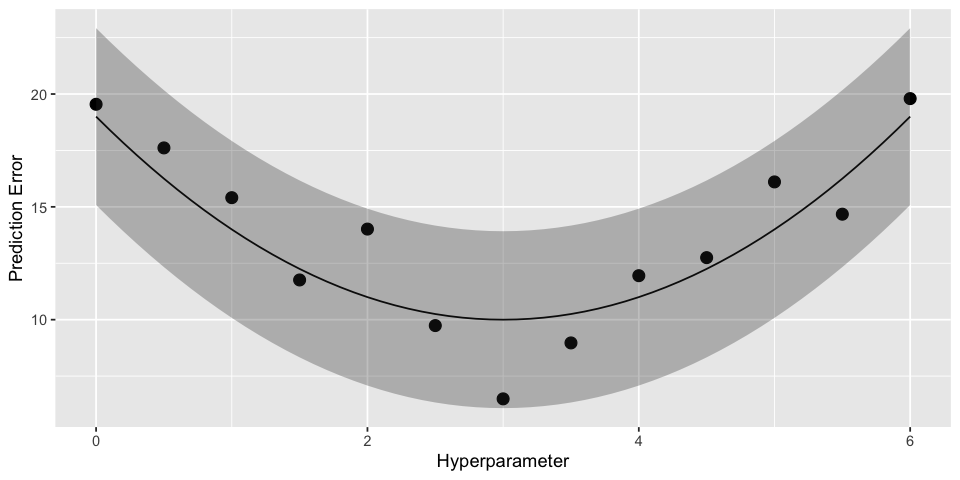

In [75]:
rlim <- 6
x <- seq(0, rlim, 0.1)
xeval <- seq(0, rlim, 0.5)
function.df <- data.frame(x=x, y=f(x, sd=0), lwr=f(x, sd=0)-1.96*2, upr=f(x, sd=0)+1.96*2)
points.df <- data.frame(x=xeval, y=f(xeval, sd=2))
p <- ggplot(points.df, aes(x=x, y=y))+
    labs(x="Hyperparameter", y = "Prediction Error")+
    geom_point(aes(), size=3)+
    geom_line(data=function.df)+
    geom_ribbon(data=function.df,aes(ymin=lwr,ymax=upr),alpha=0.3)+
    theme(legend.position="none")
p

In [93]:
x <- seq(1, rlim-1, 0.5)
n <- 10
X <- matrix(rep(x,each=n),nrow=n)
run.toy.example <- function(X, n.lambda.delta, alpha.dash){
    Y <- f(X, sd=2)
    colnames(Y) <- x
    toy.raw <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
    toy.df <- group_data(toy.raw, 'x', group_size=10)
    toy.result <- FilterTrials(toy.df, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)$H0 %>%
    select_lambda_star() %>%
    left_join(toy.raw %>% rename(Psi=Objective), by=c('Psi'))
    return(as.numeric(unique(toy.result$x)))
}

In [94]:
num.runs <- 1000
alpha <- 0.05
x.toy <- list('1'=rep(NA, num.runs), '3,6,9'=list())

for(P in c(0.1, 0.25, 0.5, 0.75, 1.)){
    x.toy[['3,6,9']][[as.character(P)]] = rep(NA, num.runs)
    seqboundary <- CalcPocockErrorAndSampleSize(n=c(3,6,9), alpha=alpha, P=P)
    alpha.dash <- seqboundary$alpha.dash
    n.lambda.delta <- seqboundary$n.delta
    for(i in 1:num.runs){
        x.toy[['3,6,9']][[as.character(P)]][i] <- run.toy.example(X,
                                                                  n.lambda.delta=n.lambda.delta,
                                                                  alpha.dash=alpha.dash)
    }
}

seqboundary <- CalcPocockErrorAndSampleSize(n=c(1), alpha=alpha)
alpha.dash <- seqboundary$alpha.dash
n.lambda.delta <- seqboundary$n.delta
for(i in 1:num.runs){
    x.toy[['1']][i] <- run.toy.example(X,
                                       n.lambda.delta=n.lambda.delta,
                                       alpha.dash=alpha.dash)
}


In [95]:
toy.hist.df <- data.frame(Method=factor(c(rep('1', num.runs),
                                          rep('3,6,9-0.1', num.runs),
                                          rep('3,6,9-0.25', num.runs),
                                          rep('3,6,9-0.5', num.runs),
                                          rep('3,6,9-0.75', num.runs),
                                          rep('3,6,9-1', num.runs))),
                          x=c(x.toy[['1']],
                              x.toy[['3,6,9']][['0.1']],
                              x.toy[['3,6,9']][['0.25']],
                              x.toy[['3,6,9']][['0.5']],
                              x.toy[['3,6,9']][['0.75']],
                              x.toy[['3,6,9']][['1']]))

In [96]:
toy.hist.df %>% group_by(Method) %>% summarise(Mean=mean(x), Var=var(x), Count=n())

Method,Mean,Var,Count
1,3.0285,0.5630008,1000
"3,6,9-0.1",3.0085,0.2098876,1000
"3,6,9-0.25",2.9905,0.1923521,1000
"3,6,9-0.5",2.9995,0.2034532,1000
"3,6,9-0.75",3.0060,0.2111752,1000
"3,6,9-1",2.9770,0.2041752,1000


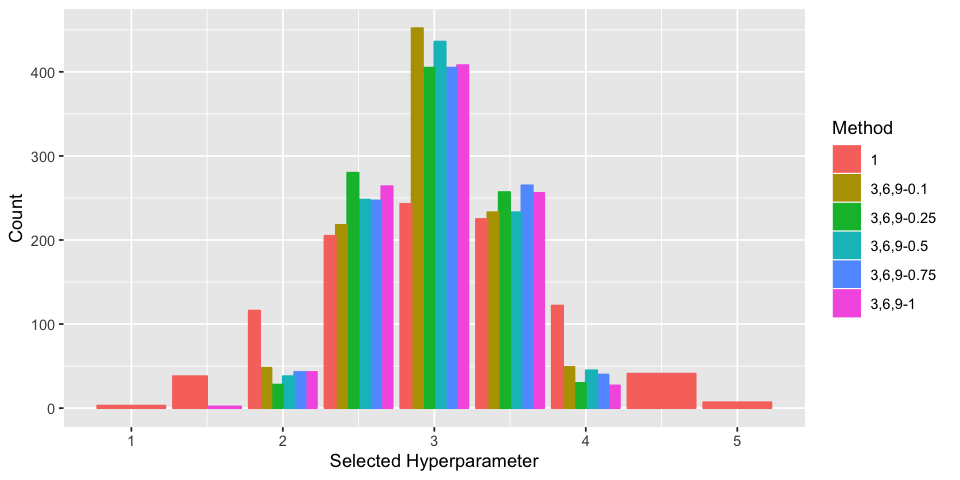

In [97]:
motivating.example.bar <- ggplot(toy.hist.df, aes(x=x, color=Method, fill=Method)) + geom_bar(position="dodge") + labs(x="Selected Hyperparameter", y = "Count")
motivating.example.bar

In [98]:
# ggsave("figures/motivating-example-results-bar.pdf", plot=motivating.example.bar, width=8, height=4)

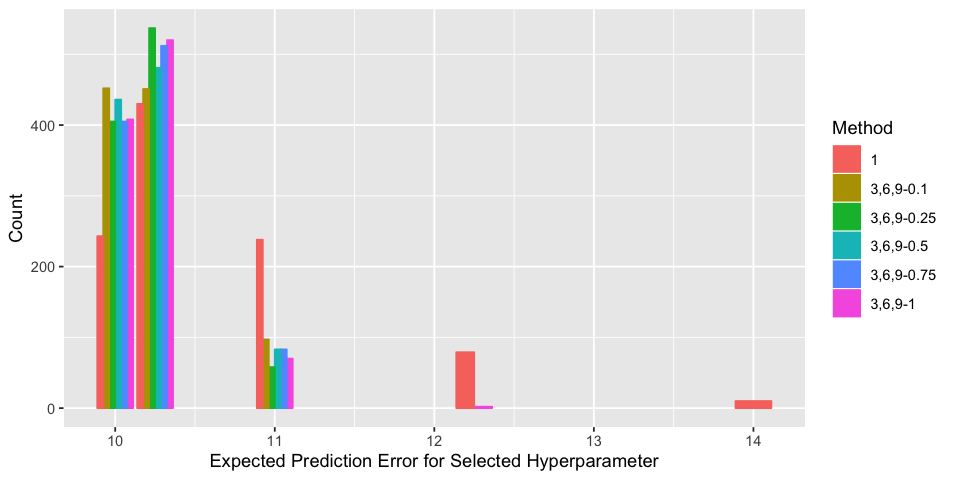

In [99]:
p <- ggplot(toy.hist.df, aes(x=f(x, sd=0), color=Method, fill=Method)) + geom_bar(position="dodge") + labs(x="Expected Prediction Error for Selected Hyperparameter", y = "Count")
p

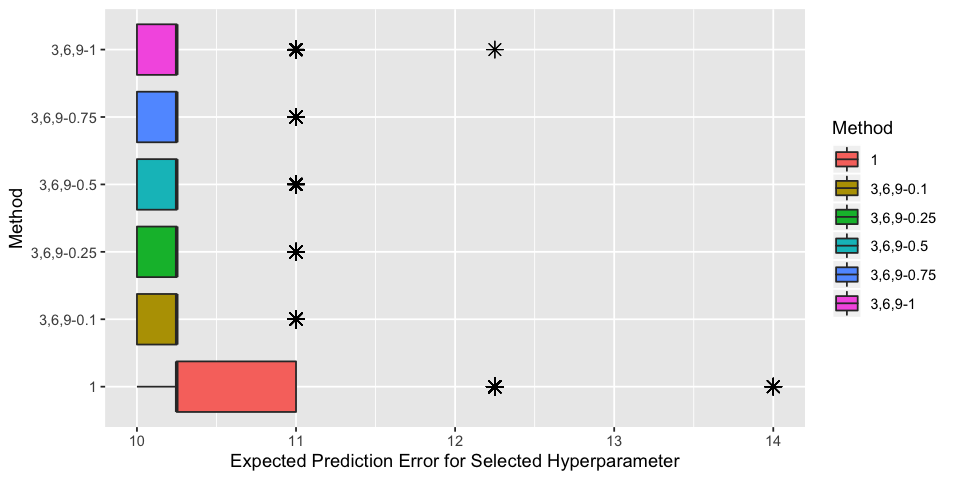

In [100]:
motivating.example.box <- ggplot(toy.hist.df, aes(x=Method, y=f(x, sd=0), fill=Method)) + 
  geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
  labs(y="Expected Prediction Error for Selected Hyperparameter") +
  coord_flip()
motivating.example.box

In [151]:
mean(f(subset(toy.hist.df, Method=='1')$x, sd=0))
var(f(subset(toy.hist.df, Method=='1')$x, sd=0))

[1] 10.52725

[1] 0.4347547

In [146]:
levels(toy.hist.df$Method)

[1] "1"     "3,6,9"

In [152]:
mean(f(subset(toy.hist.df, Method=='3,6,9')$x, sd=0))
var(f(subset(toy.hist.df, Method=='3,6,9')$x, sd=0))

[1] 10.20525

[1] 0.06925419

In [139]:
ggsave("figures/motivating-example-results-box.pdf", plot=motivating.example.box, width=8, height=4)

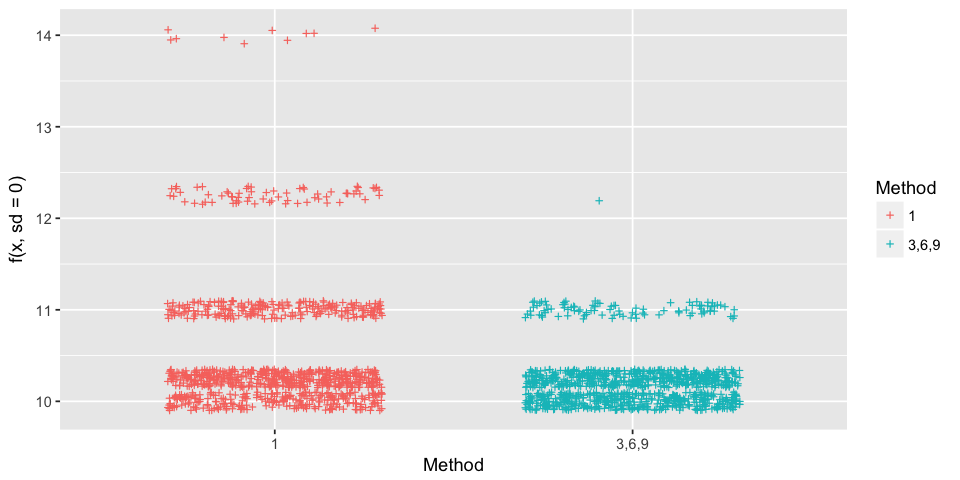

In [477]:
ggplot(toy.hist.df, aes(x=Method, y=f(x, sd=0), color=Method)) + geom_jitter(shape=3, position=position_jitter(0.3), size=1)

# Definitions

In [169]:
K.values <- c(50, 100, 150)
n.lambda <- list('1'=c(1), '5'=c(5), '10'=c(10), '3,6,9'=c(3,6,9))
num.runs <- 200

# MNIST

In [10]:
results <- read.csv("./mnistcnn/mnist-unshuffled-merged.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
mnist <- group_data(completed, 'dropout', testset="test_loss")

In [34]:
length(unique(mnist$Lambda))

[1] 592

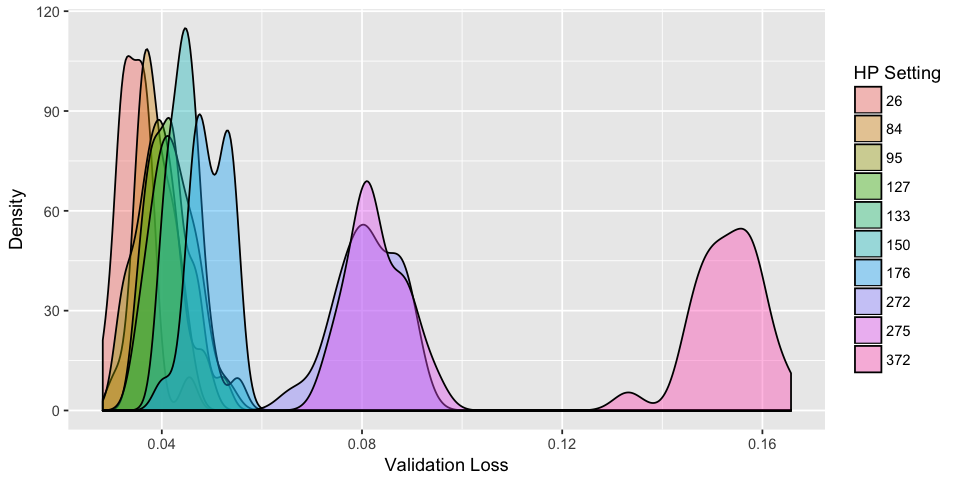

In [372]:
mnist.plot <- plot_groups(subsample_trials(subsample_groups(mnist, 10), 25), xlab="Validation Loss")
mnist.plot

In [ ]:
ggsave("figures/MNIST-density.pdf", plot=mnist.plot, width=8, height=4)

In [170]:
mnist.results <- list()
for(k in K.values) {
    mnist.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
#         cat(paste("Running K=", k, " n.lambda=", paste(as.character(n.lambda[[names(n.lambda)[i]]]), sep="", collapse=""), "\n"))
        mnist.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=mnist,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                P=0.5,
                                                                K=k)
    }
}
mnist.caption <- "Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(mnist.results, caption=mnist.caption, label="mnist-results")

\begin{table}
\caption{Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:mnist-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.69 & 1 & 1 & 0.995 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 3.185 & 2.075 & 2.385 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.955 & 0.978 & 0.972 \\ 
Avg Evaluations & 50 & 250 & 500 & 175.26 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.44 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 4.055 & 3.085 & 3.26 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.969 & 0.979 & 0.977 \\ 
Avg Evaluations & 100 & 500 & 1000 & 334.68 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.38 & 1 & 1 & 0.99 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 5.51 

In [26]:
results.shuffled <- read.csv("./mnistcnn/mnist-unshuffled-merged.csv", header = T)
completed.shuffled <- subset(results.shuffled, Status == 'COMPLETED')
mnist.shuffled <- group_data(completed.shuffled, 'dropout', testset="test_loss")

# IMDB

In [9]:
imdb.csv <- read.csv("./imdblstm/imdb_results.csv", header = T)
imdb.csv$Objective <- 1.-imdb.csv$Objective+rnorm(nrow(imdb.csv), 0, 0.000000001)
imdb.csv$test_error <- 1.-imdb.csv$test_acc
imdb <- group_data(imdb.csv, 'dropout_embedding', testset='test_error')

In [13]:
length(unique(imdb$Lambda))

[1] 553

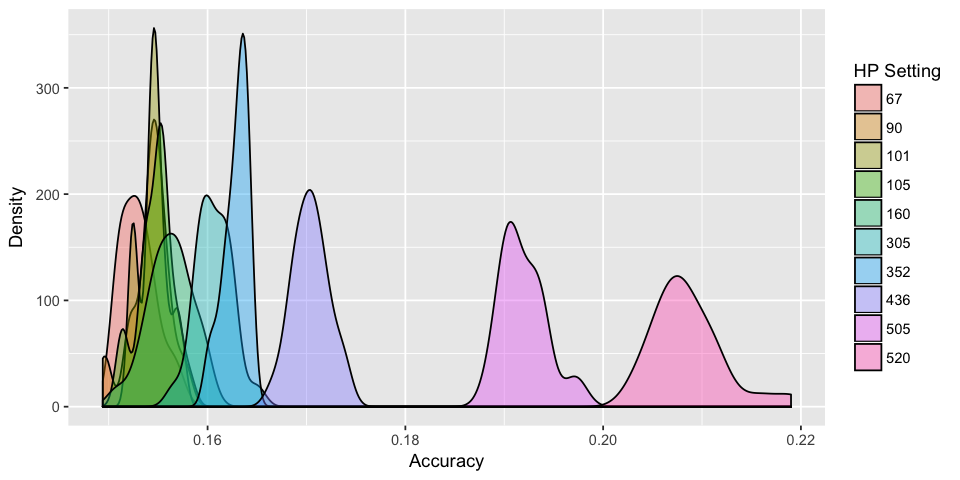

In [16]:
imdb.plot <- plot_groups(subsample_trials(subsample_groups(imdb, 10), 25), xlab="Accuracy")
imdb.plot

In [ ]:
# ggsave("figures/IMDB-density.pdf", plot=imdb.plot, width=8, height=4)

In [38]:
imdb.results <- list()
for(k in K.values) {
    imdb.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        imdb.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=imdb,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
imdb.caption <- "Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(imdb.results, caption=imdb.caption, label="imdb-results")

\begin{table}
\caption{Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:imdb-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.508 & 0.996 & 1 & 0.994 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 4.648 & 2.93 & 3.494 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.925 & 0.961 & 0.949 \\ 
Avg Evaluations & 50 & 250 & 500 & 189.072 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.404 & 1 & 0.998 & 0.996 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 6.876 & 4.068 & 5.04 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.941 & 0.969 & 0.959 \\ 
Avg Evaluations & 100 & 500 & 1000 & 358.404 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.324 & 0.998 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 8.89 & 5.182 & 

# Boston

In [8]:
boston.csv <- read.csv("./bostongbrt/boston-merged.csv", header = T)
boston.completed <- subset(boston.csv, Status == 'COMPLETED')
boston.completed <- boston.completed[order(boston.completed$Trial.ID),]
boston <- group_data(boston.completed, 'subsample', testset="test_mse")

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

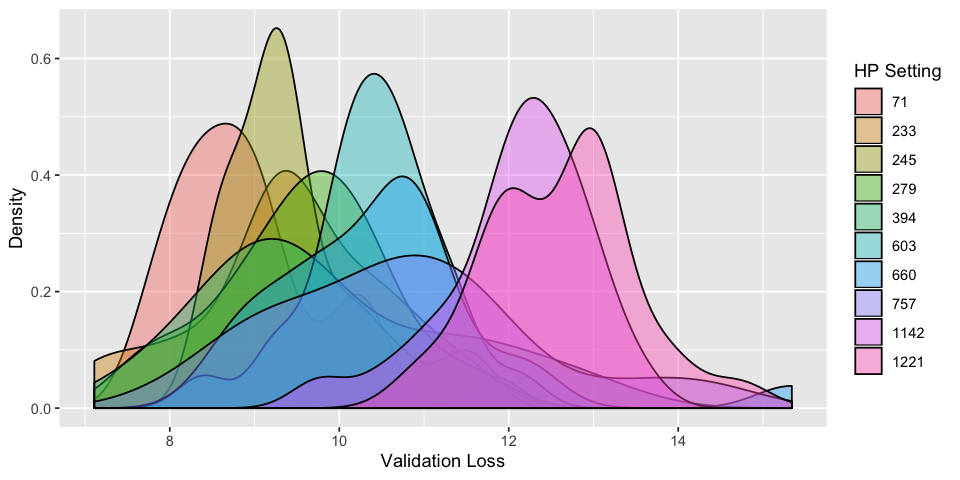

In [11]:
boston.plot <- plot_groups(subsample_trials(subsample_groups(boston, 10), 25), xlab="Validation Loss")
boston.plot

In [12]:
# ggsave("figures/Boston-density.pdf", plot=boston.plot, width=8, height=4)

In [40]:
boston.results <- list()
for(k in K.values) {
    boston.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        boston.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=boston,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
boston.caption <- "Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(boston.results, caption=boston.caption, label="boston-results")

\begin{table}
\caption{Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:boston-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.15 & 1 & 0.998 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 21.43 & 12.806 & 15.35 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.983 & 0.583 & 0.759 & 0.707 \\ 
Avg Evaluations & 50 & 250 & 500 & 304.632 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.076 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 38.132 & 23.212 & 26.472 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.991 & 0.625 & 0.776 & 0.743 \\ 
Avg Evaluations & 100 & 500 & 1000 & 574.704 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.048 & 1 & 1 & 1 \\ 
$\bar{|\mat

In [434]:
length(unique(boston$Lambda))

[1] 1494

# Cartpole

In [21]:
cartpole.csv <- read.csv("./cartpole/cartpole_results.csv", header = T)
cartpole.completed <- cartpole.csv[order(cartpole.csv$Trial.ID),]
cartpole.completed$Objective <- 1.-cartpole.completed$auc
cartpole <- group_data(cartpole.completed, 'gamma')

In [417]:
length(unique(cartpole$Lambda))

[1] 196

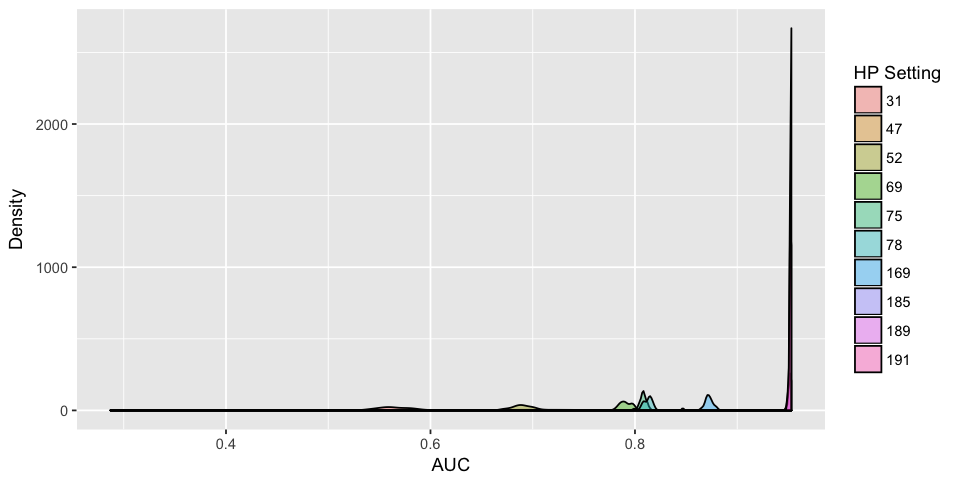

In [381]:
cartpole.plot <- plot_groups(subsample_trials(subsample_groups(cartpole, 10), 25), xlab="AUC")
cartpole.plot

In [ ]:
# ggsave("figures/Cartpole-density.pdf", plot=boston.plot, width=8, height=4)

In [382]:
cartpole.results <- list()
for(k in K.values) {
    cartpole.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        cartpole.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=cartpole,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
cartpole.caption <- "Results for the Cartpole PPO hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(cartpole.results, caption=cartpole.caption, label="cartpole-results")

\begin{table}
\caption{Results for the Cartpole PPO hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:cartpole-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.81 & 0.998 & 1 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 1.594 & 1.364 & 1.408 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.996 & 0.988 & 0.993 & 0.992 \\ 
Avg Evaluations & 50 & 250 & 500 & 161.502 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.686 & 0.998 & 0.998 & 0.994 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 2.022 & 1.582 & 1.638 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.997 & 0.99 & 0.994 & 0.993 \\ 
Avg Evaluations & 100 & 500 & 1000 & 315.846 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.636 & 0.996 & 0.996 & 0.996 \\ 
$\bar{|\mathcal{H}_0|}$ &

# Mean and Variance across repeated runs as compared to standard method

In [12]:
meanvar.num.runs <- 50
meanvar.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
meanvar.K <- list('Boston'=c(50, 100, 150), 'MNIST'=c(50, 100, 150), 'Cartpole'=c(55), 'IMDB'=c(50, 100, 150))
adjusted.K <- list()

In [21]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    meanvar.results[[dataset.name]] <- list()
    meanvar.results[[dataset.name]][['3,6,9']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9']][[as.character(k)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }

    adjusted.K[[dataset.name]] <- list()
    for (k in names(meanvar.results[[dataset.name]][['3,6,9']])) {
        adjusted.K[[dataset.name]][[k]] <- ceiling(meanvar.results[[dataset.name]][['3,6,9']][[k]][['Avg Evaluations']])
        cat(ifelse(adjusted.K[[dataset.name]][[k]] > length(unique(datasets[[dataset.name]]$Lambda)), "not enough trials", ""))
    }

    meanvar.results[[dataset.name]][['1']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['1']][[as.character(adjusted.K[[dataset.name]][[as.character(k)]])]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                                    n.lambda=c(1),
                                                                                    alpha=0.05,
                                                                                    num.runs=meanvar.num.runs,
                                                                                    K=adjusted.K[[dataset.name]][[as.character(k)]],
                                                                                    testset=T)
    }
}


In [22]:
TableMeanVar(meanvar.results, adj.k=adjusted.K)

\begin{table}
\caption{\label{tab:meanvar-results}}
\begin{center}
\begin{tabular}{lccc}
\toprule
\multicolumn{1}{c}{} & \multicolumn{1}{c}{$n_\lambda = 1$}   & \multicolumn{2}{c}{$n_\lambda = (3,6,9)$} & \multicolumn{1}{c}{$n_\lambda = (3,6,9)$-CV}\\
& & $\lambda$ sampled & $\lambda$ best \\
\midrule
MNIST& & & \\
 &\multicolumn{1}{c}{$K= 180 $}&\multicolumn{2}{c}{$K=50$}\\
Valid &0.0328(8.418e-07)&0.0335(2.480e-06)&0.0331(1.471e-06)\\
Test &0.0271(6.577e-07)&0.0275(1.495e-06)&0.0271(8.237e-07)\\
 &\multicolumn{1}{c}{$K= 334 $}&\multicolumn{2}{c}{$K=100$}\\
Valid &0.0321(3.662e-07)&0.0329(1.001e-06)&0.0323(5.581e-07)\\
Test &0.0267(4.781e-07)&0.0271(5.476e-07)&0.0269(5.712e-07)\\
 &\multicolumn{1}{c}{$K= 494 $}&\multicolumn{2}{c}{$K=150$}\\
Valid &0.0323(5.865e-07)&0.033(6.873e-07)&0.0322(3.067e-07)\\
Test &0.0268(5.573e-07)&0.0272(4.343e-07)&0.0266(2.945e-07)\\
\midrule
IMDB& & & \\
 &\multicolumn{1}{c}{$K= 186 $}&\multicolumn{2}{c}{$K=50$}\\
Valid &0.1481(1.386e-06)&0.1488(3.748e-06

### With Cross Validation

In [ ]:
datasets.shuffled <- list('MNIST'=mnist.shuffled)

In [ ]:
for(dataset.name in c('MNIST')){
    meanvar.results[[dataset.name]] <- list()
    meanvar.results[[dataset.name]][['3,6,9']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9']][[as.character(k)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }
    
    meanvar.results[[dataset.name]][['3,6,9-shuffled']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9-shuffled']][[as.character(k)]] <- EvalMetrics(tbl=datasets.shuffled[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }

    adjusted.K[[dataset.name]] <- list()
    for (k in names(meanvar.results[[dataset.name]][['3,6,9']])) {
        adjusted.K[[dataset.name]][[k]] <- ceiling(meanvar.results[[dataset.name]][['3,6,9']][[k]][['Avg Evaluations']])
        cat(ifelse(adjusted.K[[dataset.name]][[k]] > length(unique(datasets[[dataset.name]]$Lambda)), "not enough trials", ""))
    }

    meanvar.results[[dataset.name]][['1']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['1']][[as.character(adjusted.K[[dataset.name]][[as.character(k)]])]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                                    n.lambda=c(1),
                                                                                    alpha=0.05,
                                                                                    num.runs=meanvar.num.runs,
                                                                                    K=adjusted.K[[dataset.name]][[as.character(k)]],
                                                                                    testset=T)
    }
}


# Different sequential boundaries

In [119]:
seqboundary.num.runs <- 500
seqboundary.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
seqboundary.K <- list('Boston'=c(150), 'MNIST'=c(150), 'IMDB'=c(150))

In [120]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    seqboundary.results[[dataset.name]] <- list()
    seqboundary.results[[dataset.name]][['0.25']] <- list()
    seqboundary.results[[dataset.name]][['0.5']] <- list()
    seqboundary.results[[dataset.name]][['0.75']] <- list()
    seqboundary.results[[dataset.name]][['1.']] <- list()
    for(K in seqboundary.K[[dataset.name]]) {
        for(P in names(seqboundary.results[[dataset.name]])){
            seqboundary.results[[dataset.name]][[P]][[as.character(K)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                        n.lambda=c(3,6,9),
                                                                        alpha=0.05,
                                                                        num.runs=seqboundary.num.runs,
                                                                        K=K,
                                                                        P=as.numeric(P),
                                                                        testset=T) 
        }

    }
}

In [123]:
TableSeqBoundary(results=seqboundary.results)

\begin{table}
\footnotesize
\caption{\label{tab:}}
\begin{center}
\begin{tabular}{lcccc}
\toprule
$P$ & 0.25 & 0.5 & 0.75 & 1. \\

\midrule
MNIST& & & & \\

\midrule
$K= 150 $ &&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.994 & 0.996 & 0.998 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 4.614 & 4.08 & 3.988 & 3.962 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.976 & 0.979 & 0.98 & 0.98 \\ 
Avg Evaluations & 494.898 & 495.57 & 500.106 & 510.21 \\ 
$\mathbb{E}_{\mathcal{HPO}}\{\tau_{\hat{\lambda^*}}\}$($\mathrm{Var}_{\mathcal{HPO}}\{\tau_{\hat{\lambda^*}}\}$) & 0.032(3.743e-07) & 0.032(3.440e-07) & 0.032(3.621e-07) & 0.032(4.339e-07) \\ 
$\mathbb{E}_{\mathcal{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$($\mathrm{Var}_{\mathcal{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$) & 0.027(4.217e-07) & 0.027(4.432e-07) & 0.027(4.109e-07) & 0.027(4.455e-07) \\ 

\midrule
IMDB& & & & \\

\midrule
$K= 150 $ &&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 1 & 0.996 & 1 & 0.996 \\ 
$\bar{|\ma

# Type I error with real data

In [109]:
type.I.error <- list()
for(dset.name in c('MNIST', 'IMDB', 'Boston')){
    type.I.error[[dset.name]] <- list()
    for(n in c(3, 5, 10)){
        K <- floor(25/n)
        alpha <- 0.05
        num.runs <- 200
        H0.size <- rep(NA, num.runs)
        for(i in 1:num.runs){
            this.Lambda <- sample(length(unique(datasets[[dset.name]]$Lambda)), 1)
            df <- filter(datasets[[dset.name]], Lambda==this.Lambda)
            df$Lambda <- sample(c(rep(1:K, each=n), rep(K, 25-K*n)), replace=F)
            filtered.df <- filter_by_anova(df=df, alpha=alpha, verbose=F)
            H0.size[i] <- length(unique(filtered.df$Lambda))
        }
        type.I.error[[dset.name]][[as.character(n)]] <- mean(H0.size<K)
    }
}
type.I.error

Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm

$MNIST
$MNIST$`3`
[1] 0.035

$MNIST$`5`
[1] 0.07

$MNIST$`10`
[1] 0.035


$IMDB
$IMDB$`3`
[1] 0.08

$IMDB$`5`
[1] 0.04

$IMDB$`10`
[1] 0.025


$Boston
$Boston$`3`
[1] 0.06

$Boston$`5`
[1] 0.04

$Boston$`10`
[1] 0.035

In [112]:
for(dset.name in c('MNIST', 'IMDB', 'Boston')){
    K <- floor(25/12)
    alpha <- 0.05
    num.runs <- 200
    H0.size <- rep(NA, num.runs)
    for(i in 1:num.runs){
        this.Lambda <- sample(length(unique(datasets[[dset.name]]$Lambda)), 1)
        df <- filter(datasets[[dset.name]], Lambda==this.Lambda)
        df$Lambda <- sample(c(rep(1:K, each=n), rep(K, 25-K*n)), replace=F)
        filtered.df <- FilterTrials(tbl=df, n.lambda=c(3,6,9), alpha=alpha)$H0
        H0.size[i] <- length(unique(filtered.df$Lambda))
    }
    type.I.error[[dset.name]][['3,6,9']] <- mean(H0.size<K)
}
type.I.error

Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm

$MNIST
$MNIST$`3`
[1] 0.035

$MNIST$`5`
[1] 0.07

$MNIST$`10`
[1] 0.035

$MNIST$`3,6,9`
[1] 0.025


$IMDB
$IMDB$`3`
[1] 0.08

$IMDB$`5`
[1] 0.04

$IMDB$`10`
[1] 0.025

$IMDB$`3,6,9`
[1] 0.04


$Boston
$Boston$`3`
[1] 0.06

$Boston$`5`
[1] 0.04

$Boston$`10`
[1] 0.035

$Boston$`3,6,9`
[1] 0.035

# Distribution of validation losses

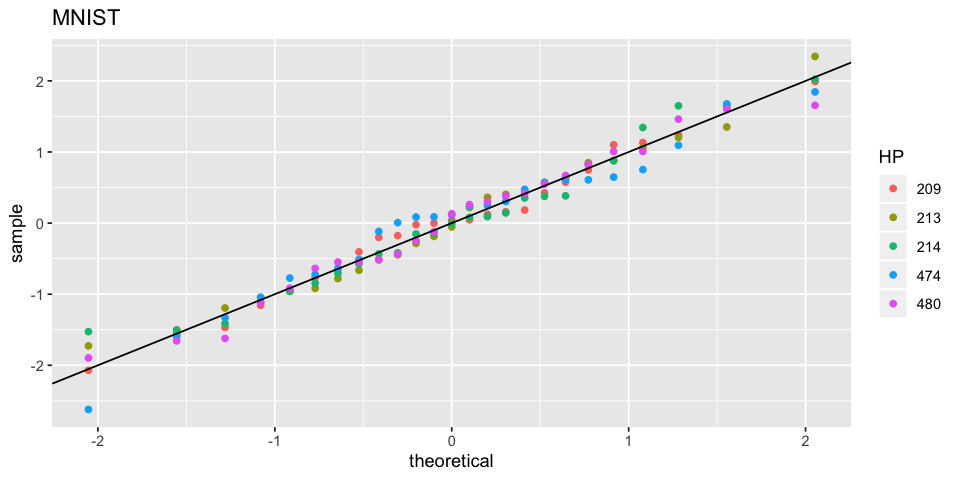

In [20]:
p <- ggplot(subsample_trials(subsample_groups(mnist, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="MNIST")
p
ggsave("figures/MNIST-qqplot.png", plot=p, width=8, height=4)

In [24]:
p <- ggplot(subsample_trials(subsample_groups(imdb, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="IMDB")
p
ggsave("figures/IMDB-qqplot.png", plot=p, width=8, height=4)

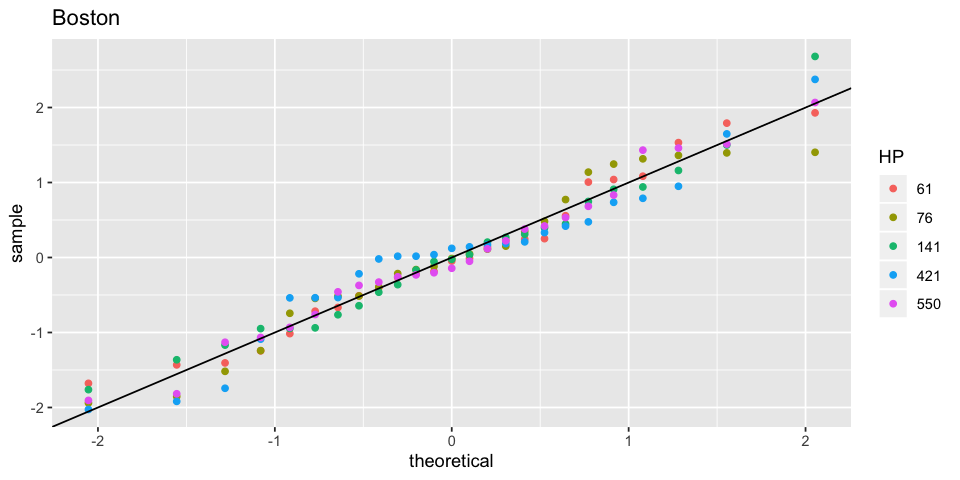

In [25]:
p <- ggplot(subsample_trials(subsample_groups(mnist, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="Boston")
p
ggsave("figures/Boston-qqplot.png", plot=p, width=8, height=4)